# Brunel Network

This is simulation of Brunel Network based on the following paper:

*Dynamics of Sparsely Connected Networks of Excitatory and Inhibitory Spiking Neurons
NICOLAS BRUNEL, Journal of Computational Neuroscience 8, 183–208 (2000)*

The simulation is done by NEST : https://www.nest-simulator.org/

The main aim is to have large spiking network of leaky-integrate and fire neurons (inhibitory and excitatory) as a ground truth. 
In next step, I will try to estimate the connectivity of this network by fitting an Auto-regressive process and measure how well this method can infere based on ground truth.

This simulation process has been run on the computing nodes of Bernstein Center Freiburg (https://www.bcf.uni-freiburg.de). So, it has benefited multiple threading.

In [1]:
#%matplotlib qt

import nest
import nest.raster_plot

import matplotlib.pyplot as plt
import numpy as np

import time
from numpy import exp

import csv
import pandas as pd
#import h5py

nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug  5 2024 06:09:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
startbuild = time.time()
nest.SetKernelStatus({"local_num_threads": 32})

----> the problem of 0.1ms resolusion should be solved. spike times in this case is given as x.y. so it need to get multiplied by 10!

In [3]:
dt = 0.1  # the resolution in ms
simtime = 10000 # Simulation time in ms
#spike_bin = 10 #bin size for downsampling the spike train  (after checking whole code this line shall be removed.)

In [4]:
sim_dict = {"Time resolution of simulation(ms)": dt, "Recording time(ms)": simtime}
sim_pd = pd.DataFrame.from_dict(sim_dict, orient="index")

In [5]:
g = 6.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

In [6]:
order = 250
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI  # number of neurons in total
N_rec = 50  # record from 50 neurons

In [7]:
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)  # total number of synapses per neuron

In [8]:
network_dic = {"Number of neurons": N_neurons, 
               "Number of exc neurons": NE, 
               "Number of inh neurons": NI, 
               "Number of exc synapses per neuron": CE, 
               "Number of inh synapses per neuron": CI, 
               "Total number of synapses per neuron": C_tot, 
               "Ratio inh/exc weight (g)": g, 
               "External rate relative to threshold rate (eta)": eta}

network_pd = pd.DataFrame.from_dict(network_dic, orient='index')

In [8]:
delay = 1.5  # synaptic delay in ms
tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 8.  # postsynaptic amplitude in mV
J_ex = J  # amplitude of excitatory postsynaptic potential
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential

In [10]:
neuron_dic = {"time constant of membrane potential(ms)": tauMem, "membrane threshold potential(mV)": theta, "postsynaptic amplitude(mV)": J, 
              "J_ex": J_ex, "J_in": J_in, "synaptic delay(ms)": delay, "C_m": 1.0,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,}
neuron_pd = pd.DataFrame.from_dict(neuron_dic, orient='index')

In [9]:
nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 10000.0 * nu_ex * CE

output_dic = {"nu_th": nu_th, "nu_ex": nu_ex, "p_rate": p_rate}
output_pd = pd.DataFrame.from_dict(output_dic, orient='index')

In [12]:
print("Simulation Parameters: \n")
display(sim_pd)
print("Network Parameters: \n")
display(network_pd)
print("Neuron Parameters: \n")
display(neuron_pd)
print("Output Parameters: \n")
display(output_pd)

Simulation Parameters: 



,0
Time resolution of simulation(ms),0.1
Recording time(ms),10000.0


Network Parameters: 



,0
Number of neurons,1250.0
Number of exc neurons,1000.0
Number of inh neurons,250.0
Number of exc synapses per neuron,100.0
Number of inh synapses per neuron,25.0
Total number of synapses per neuron,125.0
Ratio inh/exc weight (g),6.0
External rate relative to threshold rate (eta),2.0


Neuron Parameters: 



,0
time constant of membrane potential(ms),20.0
membrane threshold potential(mV),20.0
postsynaptic amplitude(mV),8.0
J_ex,8.0
J_in,-48.0
synaptic delay(ms),1.5
C_m,1.0
t_ref,2.0
E_L,0.0
V_reset,0.0


Output Parameters: 



,0
nu_th,0.00125
nu_ex,0.00250
p_rate,2500.00000


In [10]:
nest.SetKernelStatus({"resolution": dt, "print_time": True,
                      "overwrite_files": True})

print("Building network")

Building network

Oct 13 16:08:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


DC generator was for testing something!

<font color="red">This block didn't compile.</font>

In [11]:
nest.SetDefaults("iaf_psc_delta", neuron_params)
nest.SetDefaults("poisson_generator", {"rate": p_rate})

#DC generator
nest.SetDefaults("dc_generator", {"amplitude": 6.})

In [12]:
nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)

#DC Generator
noise = nest.Create("poisson_generator")
#noise = nest.Create("dc_generator")

#espikes = nest.Create("spike_detector")
#ispikes = nest.Create("spike_detector")

espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")

In [13]:
#neuron test
neuron_test = nest.Create("iaf_psc_delta", 1)

In [14]:
#neuron test multimeter
#multimeter_neuron = nest.Create("multimeter")
#nest.SetStatus(multimeter_neuron, {"withtime":True, "record_from":["V_m"]})

multimeter_network_E = nest.Create("multimeter")
#nest.SetStatus(multimeter_network_E, {"withtime":True, "record_from":["V_m"]})
nest.SetStatus(multimeter_network_E, {"record_from":["V_m"]})

multimeter_network_I = nest.Create("multimeter")
#nest.SetStatus(multimeter_network_I, {"withtime":True, "record_from":["V_m"]})
nest.SetStatus(multimeter_network_I, {"record_from":["V_m"]})

In [15]:
#spike detectors
#sp_detector = nest.Create("spike_recorder", params={"withtime": True, "withgid": True, "to_file": True, "label": "spike_data", "record_to": "hdf5"})
sp_detector = nest.Create("spike_recorder")

<font color="red">This block didn't compile.</font>

In [19]:
nest.SetStatus(espikes, [{"label": "brunel-py-ex",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

nest.SetStatus(ispikes, [{"label": "brunel-py-in",
                          "withtime": True,
                          "withgid": True,
                          "to_file": True}])

print("Connecting devices")

NESTErrors.DictError: DictError in SLI function SetStatus_id: Unused dictionary items:  withtime withgid to_file

In [16]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

In [17]:
nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

#neuron test noise
nest.Connect(noise, neuron_test, syn_spec="excitatory")

In [18]:
#connecting multimeters
#nest.Connect(multimeter_neuron, neuron_test)
nest.Connect(multimeter_network_E, nodes_ex)
nest.Connect(multimeter_network_I, nodes_in)

In [19]:
#connect spike detector
nest.Connect(nodes_ex + nodes_in, sp_detector, syn_spec="excitatory")

In [20]:
nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

Connecting network
Excitatory connections


In [21]:
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

Inhibitory connections


In [22]:
conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

In [23]:
endbuild = time.time()

In [26]:
print("Simulating")

nest.Simulate(simtime)

Simulating


In [27]:
endsimulate = time.time()

In [28]:
events_ex = nest.GetStatus(espikes, "n_events")[0]
events_in = nest.GetStatus(ispikes, "n_events")[0]

In [29]:
rate_ex = events_ex / simtime * 1000.0 / N_rec
rate_in = events_in / simtime * 1000.0 / N_rec

In [30]:
num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

In [31]:
build_time = endbuild - startbuild
sim_time = endsimulate - endbuild

In [32]:
print("Brunel network simulation (Python)")
print("Number of neurons : {0}".format(N_neurons))
print("Number of synapses: {0}".format(num_synapses))
print("       Exitatory  : {0}".format(int(CE * N_neurons) + N_neurons))
print("       Inhibitory : {0}".format(int(CI * N_neurons)))
print("Excitatory rate   : %.2f Hz" % rate_ex)
print("Inhibitory rate   : %.2f Hz" % rate_in)
print("Building time     : %.2f s" % build_time)
print("Simulation time   : %.2f s" % sim_time)

Brunel network simulation (Python)
Number of neurons : 1250
Number of synapses: 158851
       Exitatory  : 126250
       Inhibitory : 31250
Excitatory rate   : 215.15 Hz
Inhibitory rate   : 213.38 Hz
Building time     : 42.04 s
Simulation time   : 168.02 s


/tmp/ipykernel_4900/1493148879.py:1: MatplotlibDeprecationWarning:The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


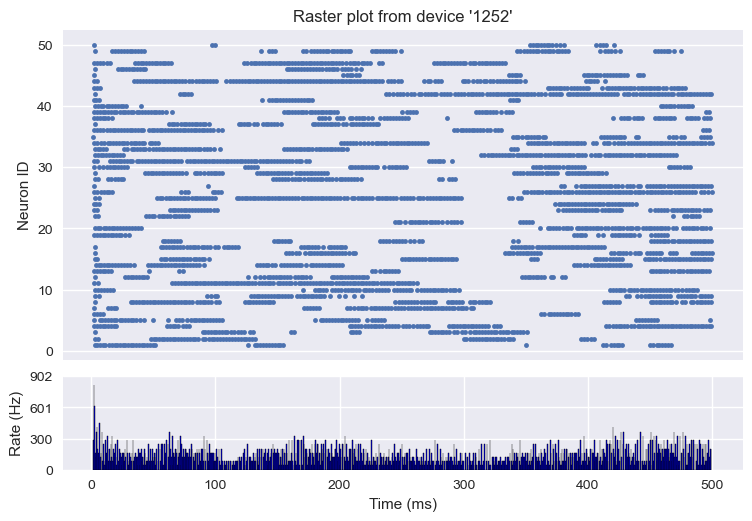

In [ ]:
plt.style.use('seaborn')
nest.raster_plot.from_device(espikes, hist=True, hist_binwidth=0.5)

Following blocks are for testig the whole process. signals and ...

In [33]:
#reading spike detector
sp_detector_data = nest.GetStatus(sp_detector, "events")[0]
sp_times = sp_detector_data["times"]
sp_senders = sp_detector_data["senders"]

In [ ]:
np.save("sp_times-60e6-ms", sp_times)
np.save("sp_senders-60e6-ms", sp_senders)

This block may get improved as submatrix selection which had done for problem of hidden nodes.

In [34]:
#Get Connectivity matrix
conn_tuple = nest.GetConnections(source= nodes_ex+nodes_in, target=nodes_ex+nodes_in)

conn_matrix = np.zeros((N_neurons, N_neurons))

sources = nest.GetStatus(conn_tuple, 'source')
targets = nest.GetStatus(conn_tuple, 'target')
weights = nest.GetStatus(conn_tuple, 'weight')

counter = 0

for i, j in zip(sources, targets):
    conn_matrix[j-1, i-1] = weights[counter]
    counter+=1
    
np.save("connectivity-60e6-ms", conn_matrix)

In [35]:
spikes = np.histogram2d(sp_senders, sp_times, bins=[range(1, 1252), np.arange(0, simtime+1, 1)])[0]

#np.save("spikes-60e6-ms", spikes)
np.shape(spikes)

(1250, 10000)

In [36]:
spikes.to_file("spikes.h5", "w")

AttributeError: 'numpy.ndarray' object has no attribute 'to_file'

This codes has been left here to be used later.

In [ ]:
with open("runs_variable.csv", "w+") as csvfile:
    fieldnames = ["sim_time", "order", "eta", "epsilon", "g", "j", "p_rate", "rate_ex", "rate_in", "num_syn"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

In [ ]:
#writing multiple runs variables into a csv, it should be merged with the correlation results in the var nb.
fieldnames = ["sim_time", "order", "eta", "epsilon", "g", "j", "p_rate", "rate_ex", "rate_in", "num_syn"]
variable_dict = {"sim_time": simtime, "order": order, "eta": eta, "epsilon": epsilon, "g": g, "j": J,
                 "p_rate": p_rate, "rate_ex": rate_ex, "rate_in": rate_in, "num_syn": num_synapses}

with open("runs_variable.csv", "a") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writerow(variable_dict)